In [1]:
# The MIT License (MIT) Copyright (c) 2023 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/30_DDIM_cfg.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Classifier-Free Diffusion Guidance

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

torch.__version__

'2.2.0+cu121'

In [3]:
torch.manual_seed(77)

## 1.- Dataset

In [4]:
batch_size = 128
img_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

train_data = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

In [5]:
len(train_loader.dataset)

60000

In [6]:
test_batch, test_labels = next(iter(train_loader))
test_batch.shape, test_labels.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

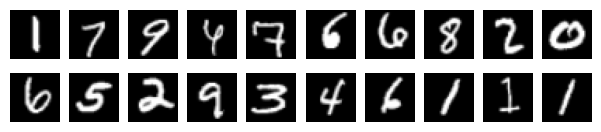

In [7]:
# Define a function to plot images with titles
def plot_batch(images, w=None):
    images = images * 0.5 + 0.5
    fig, axes = plt.subplots(2, 10, figsize=(7.5, 1.5))
    axes = axes.flatten()

    for i in range(len(images)):
        axes[i].imshow(images[i].permute(1, 2, 0), cmap='gray')
        axes[i].axis('off')
    
    if w is not None:
        fig.suptitle(f'w= {w}', y=1.0)
    plt.show()

# Select a batch of images and their corresponding targets
n_plot = 20
batch_images = test_batch[:n_plot]

# Plot the batch of images
plot_batch(batch_images)

## 2.- Model
### UNet

In [8]:
import torch.nn as nn
import math

In [9]:
class PositionalEmbedding(nn.Module):
    def __init__(self, dim, scale=1.0):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.scale = scale

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / half_dim
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = torch.outer(x * self.scale, emb)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [10]:
test_labels

tensor([1, 7, 9, 4, 7, 6, 6, 8, 2, 0, 6, 5, 2, 9, 3, 4, 6, 1, 1, 1, 3, 3, 0, 3,
        0, 4, 7, 2, 7, 9, 5, 7, 4, 3, 5, 4, 3, 0, 6, 6, 2, 7, 3, 8, 8, 0, 1, 2,
        7, 2, 5, 8, 7, 9, 3, 4, 7, 7, 5, 2, 4, 1, 8, 6, 4, 7, 7, 3, 6, 3, 8, 0,
        0, 4, 9, 7, 2, 0, 8, 2, 4, 7, 7, 6, 3, 8, 5, 1, 6, 2, 7, 8, 2, 0, 5, 9,
        3, 9, 5, 0, 8, 5, 7, 3, 7, 8, 5, 7, 7, 8, 4, 5, 5, 4, 3, 4, 9, 5, 1, 8,
        2, 5, 4, 8, 6, 8, 1, 2])

In [11]:
class DropEmbedding(nn.Module):
    def __init__(self, n_classes, emb_dim, drop_p):
        super().__init__()
        self.emb = nn.Embedding(n_classes + 1, emb_dim)
        self.n_classes = n_classes
        self.drop_p = drop_p

    def forward(self, labels, train, dropout=False):
        if train  or (dropout is True):
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.drop_p
            labels = torch.where(drop_ids, self.n_classes, labels)
        x = self.emb(labels)
        return x

l = DropEmbedding(10, 2, 0.5)
l.train()
l(test_labels[:10], True)

tensor([[-1.4728, -0.0996],
        [-1.3664,  1.1565],
        [ 2.3701,  1.3993],
        [-0.8564, -1.2032],
        [ 1.3308, -0.4382],
        [ 0.3704,  0.7420],
        [-1.3664,  1.1565],
        [-1.6271,  0.8957],
        [-1.3664,  1.1565],
        [-1.3664,  1.1565]], grad_fn=<EmbeddingBackward0>)

In [12]:
l(test_labels[:10], False)

tensor([[-1.4728, -0.0996],
        [ 1.3308, -0.4382],
        [ 2.3701,  1.3993],
        [-0.8564, -1.2032],
        [ 1.3308, -0.4382],
        [ 0.3704,  0.7420],
        [ 0.3704,  0.7420],
        [-1.6271,  0.8957],
        [-0.9345, -0.6766],
        [-2.4491,  0.7654]], grad_fn=<EmbeddingBackward0>)

In [13]:
class upBlock(nn.Module):
    def __init__(self, in_planes, out_planes, emb_dim):
        super(upBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_planes, in_planes, 3, 1, 1, bias=False),
            nn.GroupNorm(num_channels=in_planes, 
                         num_groups=in_planes // 4),
            nn.SiLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_planes, out_planes, 3, 1, 1, bias=False),
            nn.GroupNorm(num_channels=out_planes, 
                         num_groups=out_planes // 4),
            nn.SiLU(),
        )
        self.emb = nn.Sequential(
            nn.Linear(emb_dim, out_planes),
            nn.SiLU(),
        )

    def forward(self, x, t):
        x = self.conv1(x) + x
        return self.conv2(x) + self.emb(t)[:, :, None, None]


class DownBlock(nn.Module):
    def __init__(self, in_planes, out_planes, emb_dim):
        super(DownBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_planes, in_planes, 3, 1, 1, bias=False),
            nn.GroupNorm(num_channels=in_planes, 
                         num_groups=in_planes // 4),
            nn.SiLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, 3, 2, 1, bias=False),
            nn.GroupNorm(num_channels=out_planes, 
                         num_groups=out_planes // 4),
            nn.SiLU(),
        )
        self.emb = nn.Sequential(
            nn.Linear(emb_dim, out_planes),
            nn.SiLU(),
        )

    def forward(self, x, t):
        x = self.conv1(x) + x
        return self.conv2(x) + self.emb(t)[:, :, None, None]


class UNet(nn.Module):
    def __init__(self, n_channels=64, emb_dim=64, 
                 norm_num_groups=32, n_classes=10):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.inp = nn.Sequential(
            nn.Conv2d(1, n_channels, 3, 1, 1, bias=False),
            nn.GroupNorm(num_channels=n_channels, 
                         num_groups=n_channels // 4),
            nn.SiLU(),
        )

        self.down1 = DownBlock(n_channels, n_channels*2, emb_dim)
        self.down2 = DownBlock(n_channels*2, n_channels*4, emb_dim)

        self.up1 = upBlock(n_channels*4, n_channels*2, emb_dim)
        self.up2 = upBlock(n_channels*4, n_channels, emb_dim)

        self.out = nn.Sequential(
            nn.GroupNorm(num_channels=n_channels, 
                         num_groups=n_channels // 4),
            nn.SiLU(),
            nn.Conv2d(n_channels, 1, 3, 1, 1, bias=False),
        )

        self.emb = nn.Sequential(
            PositionalEmbedding(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim),
        )
        # self.c_emb = nn.Embedding(n_classes, emb_dim)
        self.y_emb = DropEmbedding(n_classes, emb_dim, drop_p=0.4)

    def forward(self, x, t):
        t, c = t
        B = x.shape[0]
        emb = self.emb(t)
        c_emb = self.y_emb(c, self.training)
        emb = emb + c_emb

        x1 = self.inp(x)
        x2 = self.down1(x1, emb)
        x3 = self.down2(x2, emb)

        x = self.up1(x3, emb)
        x = self.up2(torch.concat([x, x2], 1), emb)
        x = self.out(x)
        return x

    def forward_cfg(self, x, t, w=0.0):
        t, c = t
        B = x.shape[0]
        x = torch.cat([x, x], 0)
        t = torch.cat([t, t], 0)
        c_uncond = torch.tensor([self.n_classes] * B, device=x.device)
        c = torch.cat([c, c_uncond], 0)
        x = self.forward(x, [t, c])
        cond_x, uncond_x = torch.split(x, len(x) // 2, dim=0)
        x = cond_x + w * (cond_x - uncond_x)
        return x


unet = UNet(64, 64)
noise_test = torch.randn(test_batch.shape)
t_test = torch.ones(test_batch.shape[0])
c_test = torch.ones(test_batch.shape[0])
out_batch = unet(test_batch, [t_test, test_labels])
out_batch = unet.forward_cfg(test_batch, [t_test, test_labels])
out_batch.shape, test_batch.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128, 1, 32, 32]))

### Diffusion

#### DDPM

<img src="../img/ddpm.png" width="900"/>

__Image taken from Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. Advances in neural information processing systems, 33, 6840-6851.__

#### DDIM

<img src="../img/ddim1.png" width="900"/>
<img src="../img/ddim2.png" width="500"/>

__Image taken from Song, J., Meng, C., & Ermon, S. (2020). Denoising diffusion implicit models. arXiv preprint arXiv:2010.02502.__

#### Classifier-Free guidance

<img src="../img/free_guidance.png" width="900"/>

__Image taken from Ho, Jonathan, and Tim Salimans. "Classifier-free diffusion guidance." arXiv preprint arXiv:2207.12598 (2022).__


In [14]:
class Diffusion(object):
    def __init__(self, n_steps, beta_min, beta_max):
        self.n_steps = n_steps
        self.betas = torch.linspace(beta_min, beta_max, n_steps)
        self.alphas = 1.0 - self.betas
        self.alphabar = torch.cumprod(self.alphas, dim=0)
        self.sigma = self.betas.sqrt()

    def diffuse(self, x0):
        B = len(x0)
        device = x0.device
        self.alphabar = self.alphabar.to(device)
        t = torch.randint(0, self.n_steps, (B,), dtype=torch.long).to(device)
        noise = torch.randn(x0.shape).to(device)
        alpha_t = self.alphabar[t].reshape(-1, 1, 1, 1).to(device)
        xt = alpha_t.sqrt() * x0 + (1 - alpha_t).sqrt() * noise
        return xt, t, noise

    def sample(self, model, x_shape, label, steps=100, eta=1., w=0.0, seed=None):
        # Set up seed and context manager
        if seed is not None:
            with torch.random.fork_rng():
                torch.manual_seed(seed)
                return self._sample_internal(model, x_shape, label, steps, eta, w)
        else:
            return self._sample_internal(model, x_shape, label, steps, eta, w)

    @torch.no_grad()
    def _sample_internal(self, model, x_shape, label, steps=50, eta=1., w=0.0):
        device = next(model.parameters()).device
        model.eval()
        x_t = torch.randn(x_shape, device=device)
        label = label.to(device)
        step_size = int(self.n_steps / steps)
        for t in reversed(range(0, self.n_steps, step_size)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            a_next = self.alphabar[t - step_size] if t > 0 else torch.tensor(1)
            a = self.alphabar[t]
            b_next = 1 - a_next
            b = 1 - self.alphabar[t]
            s = ((b_next / b).sqrt() * (1 - a / a_next).sqrt()) * eta
            noise_pred = model.forward_cfg(x_t, [t_batch, label], w)
            x_0 = (x_t - b.sqrt() * noise_pred) / a.sqrt()
            x_t = (b_next - s ** 2).sqrt() * noise_pred
            x_t = a_next.sqrt() * x_0 + x_t + s * z
        return x_t.cpu()


diffusion = Diffusion(n_steps=500, beta_min=0.0001, beta_max=0.02)
noisy_img, t, noise = diffusion.diffuse(test_batch)
noisy_img.shape, t.shape, noise.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]), torch.Size([128, 1, 32, 32]))

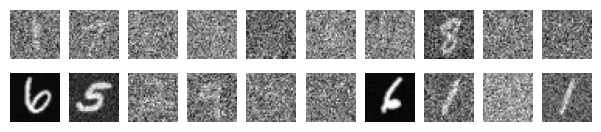

In [15]:
plot_batch(noisy_img[:n_plot])

In [16]:
optimizer = optim.Adam(unet.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [18]:
unet.to(device)

UNet(
  (inp): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GroupNorm(16, 64, eps=1e-05, affine=True)
    (2): SiLU()
  )
  (down1): DownBlock(
    (conv1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(16, 64, eps=1e-05, affine=True)
      (2): SiLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): SiLU()
    )
    (emb): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): SiLU()
    )
  )
  (down2): DownBlock(
    (conv1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): SiLU()
    )
    (conv2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=

In [19]:
x_shape = (n_plot, 1, img_size, img_size)

In [20]:
label = torch.randint(0, 10, (n_plot,))
label

tensor([0, 4, 5, 8, 4, 5, 0, 2, 0, 0, 8, 3, 9, 8, 4, 0, 0, 3, 9, 1])

## 3.- Training

Time for epoch 0 is 12.7218 sec Train loss: 0.1264


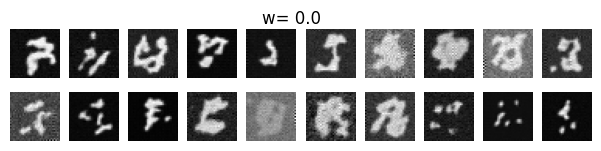

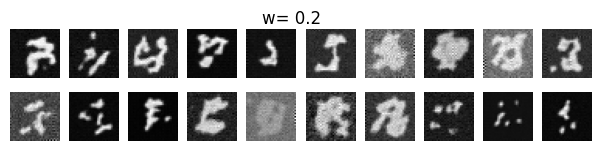

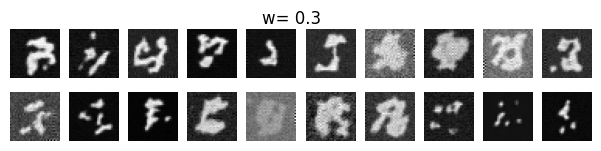

Time for epoch 1 is 12.4115 sec Train loss: 0.0450
Time for epoch 2 is 12.4606 sec Train loss: 0.0381
Time for epoch 3 is 12.4366 sec Train loss: 0.0346
Time for epoch 4 is 12.5553 sec Train loss: 0.0322
Time for epoch 5 is 12.5116 sec Train loss: 0.0305


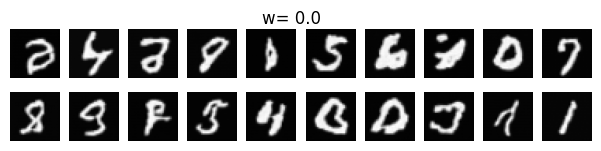

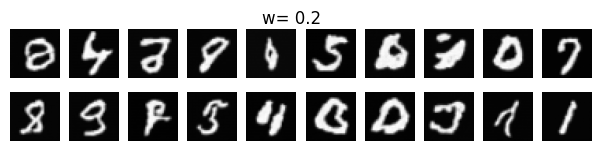

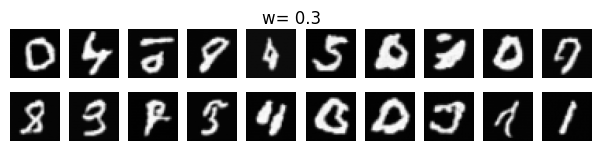

Time for epoch 6 is 12.4710 sec Train loss: 0.0295
Time for epoch 7 is 12.6022 sec Train loss: 0.0285
Time for epoch 8 is 12.6064 sec Train loss: 0.0282
Time for epoch 9 is 12.5568 sec Train loss: 0.0276
Time for epoch 10 is 12.5137 sec Train loss: 0.0271


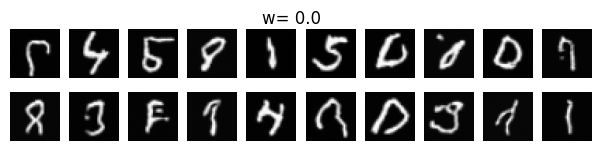

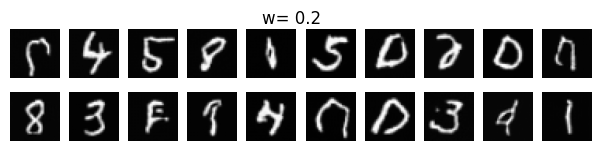

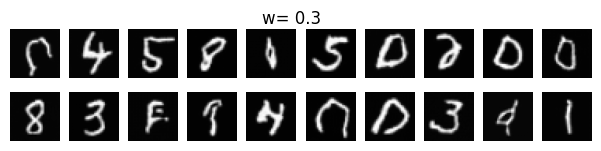

Time for epoch 11 is 12.5310 sec Train loss: 0.0266
Time for epoch 12 is 12.5855 sec Train loss: 0.0265
Time for epoch 13 is 12.4752 sec Train loss: 0.0262
Time for epoch 14 is 12.5162 sec Train loss: 0.0256
Time for epoch 15 is 12.5748 sec Train loss: 0.0259


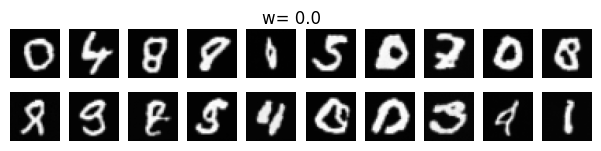

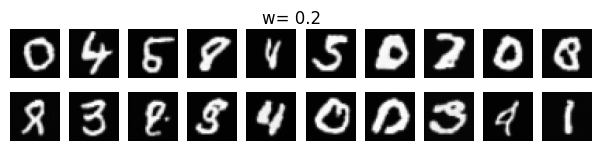

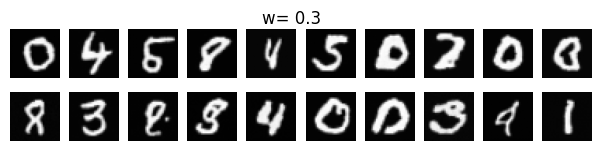

Time for epoch 16 is 12.5064 sec Train loss: 0.0253
Time for epoch 17 is 12.6371 sec Train loss: 0.0254
Time for epoch 18 is 12.4789 sec Train loss: 0.0251
Time for epoch 19 is 12.5244 sec Train loss: 0.0252
Time for epoch 20 is 12.5094 sec Train loss: 0.0246


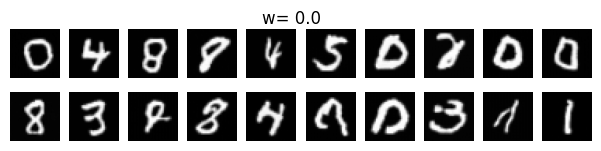

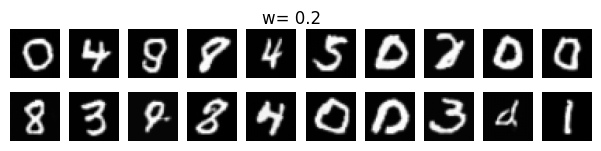

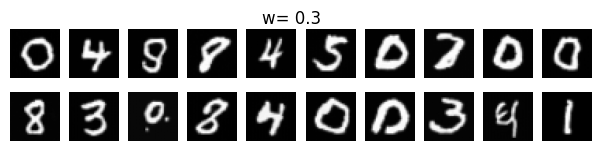

In [21]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        xt, t, noise = diffusion.diffuse(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(xt, [t, labels])
        loss = loss_fn(outputs, noise)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f'Time for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')


epochs = 20
seed = 42
for epoch in range(epochs + 1):
    train(unet, device, train_loader, optimizer, epoch)
    if epoch % 5 == 0:
        w = 0.0
        gen_ddim = diffusion.sample(unet, x_shape, label, w=w, seed=seed)
        plot_batch(gen_ddim, w)
        w = 0.2
        gen_ddim = diffusion.sample(unet, x_shape, label, w=w, seed=seed)
        plot_batch(gen_ddim, w)
        w = 0.3
        gen_ddim = diffusion.sample(unet, x_shape, label, w=w, seed=seed)
        plot_batch(gen_ddim, w)